#Inports and initial setup

In [ ]:
import tensorflow as tf
import os
import pathlib
import time
import datetime
from IPython import display
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage import io, color
import cv2
import random
import torch
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [ ]:
### Our data is stored on drive so we need to mount drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Ultrasound dataset class

In [ ]:
class UltrasoundDataset(Dataset):
  def __init__ (self,image_dir,mask_dir,transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.images = os.listdir(image_dir)
    self.transform = transform
    
  def __len__ (self):
    return len(self.images)

  def __getitem__ (self,index):
    img_path = os.path.join(self.image_dir,self.images[index])
    mask_path = os.path.join(self.mask_dir,self.images[index].replace(".png","_Annotation.png"))
    image = np.array(Image.open(img_path))
    mask = np.array(Image.open(mask_path).convert("L")) # ,dtype = np.float32)

    return image,mask

In [ ]:
### Train is a tuple length 999, storing the input and the mask image as numpy arrays

train = UltrasoundDataset("/content/drive/MyDrive/BIA Final Project/Data/train_images","/content/drive/MyDrive/BIA Final Project/Data/train_masks")

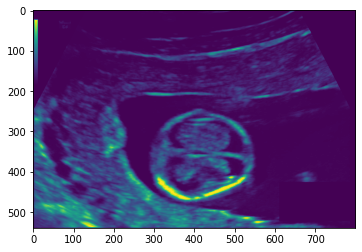

In [ ]:
img, msk = train.__getitem__(0)
plt.imshow(train.__getitem__(0)[0])

## Data processing and preparation

The load function takes either a string or Tensor input as image_file and transforms the image according to pix2pix parameters, ultimately returning the input and real image as uint8 tensors

In [ ]:
def load(mask, input):
  ### Change shape from (540, 800) to (540, 800, 1)
  input = input[:, :, np.newaxis]
  mask = mask[:, :, np.newaxis]

  ### Resize to (540, 800, 3)
  temp_shape = np.zeros([540, 800, 3])
  temp_shape[:,:,] = input
  input = temp_shape
  temp_shape = np.zeros([540, 800, 3])
  temp_shape[:,:,] = mask
  mask = temp_shape

  ### Convert numpy to tf
  mask_tf = tf.convert_to_tensor(mask)
  mask_tf = tf.cast(mask_tf, tf.uint8)
  input_tf = tf.convert_to_tensor(input)
  input_tf = tf.cast(input_tf, tf.uint8)

  return mask_tf, input_tf

In [ ]:
BUFFER_SIZE = 805

# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1

# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
### re-define resize function for our uses
def resize(input_image, real_image, height, width):

  input_image = tf.image.resize(input_image, [height, width],
                                
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

Lets try this function on the first image in the dataset

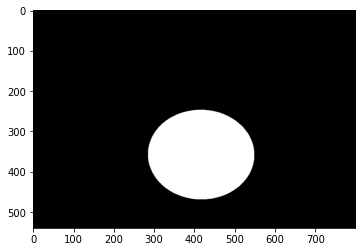

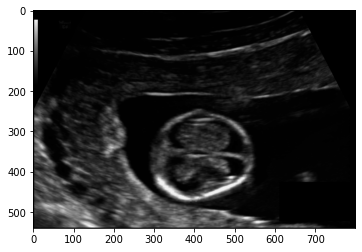

In [ ]:
image, mask = train.__getitem__(0)
inp, re = load(mask, image)

plt.figure()
plt.imshow(tf.cast(inp, tf.float32)/ 255.0)
plt.figure()
plt.imshow(tf.cast(re, tf.float32) / 255.0)

Pix2Pix requires the application of random jitter and mirror functions to preprocess/transform the training set.

Define several functions that:

1. Resize each `256 x 256` image to a larger height and width—`286 x 286`.
2. Randomly crop it back to `256 x 256`.
3. Randomly flip the image horizontally i.e. left to right (random mirroring).
4. Normalize the images to the `[-1, 1]` range.

In [ ]:
# Grabs a random 256x256 crop of the 286x286 upscaled image
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [ ]:
# Normalizing the images to range [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

You can inspect some of the preprocessed output:

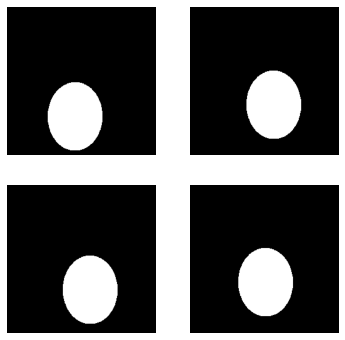

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(tf.cast(inp, tf.float32), tf.cast(re, tf.float32))
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

Here we load in the mask and image tensors, resize them, and add them to the respective lists: train_images and train_masks

In [ ]:
train_images = []
train_masks = []

for i in range (len(train)):
  image, mask = train.__getitem__(i)
  if(image.shape[0]==540 and image.shape[1]==800):  ### For whatever reason some of the images arent of size (540, 800) so we exclude those for simplicity
    input, real = load(mask, image)
    input, real = random_jitter(input, real)
    train_images.append(real)
    train_masks.append(input)

In [ ]:
print(train_masks[0].shape)

(256, 256, 3)


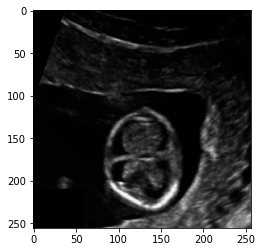

In [ ]:
plt.imshow(train_images[0])

# Generator

Define the downsampler (encoder):

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

Define the upsampler (decoder):

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

Define the generator with the downsampler and the upsampler:

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  ### The down part of the UNET model
  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  ### The up part of the UNET model
  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and concatenating the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

Visualize the generator model architecture:

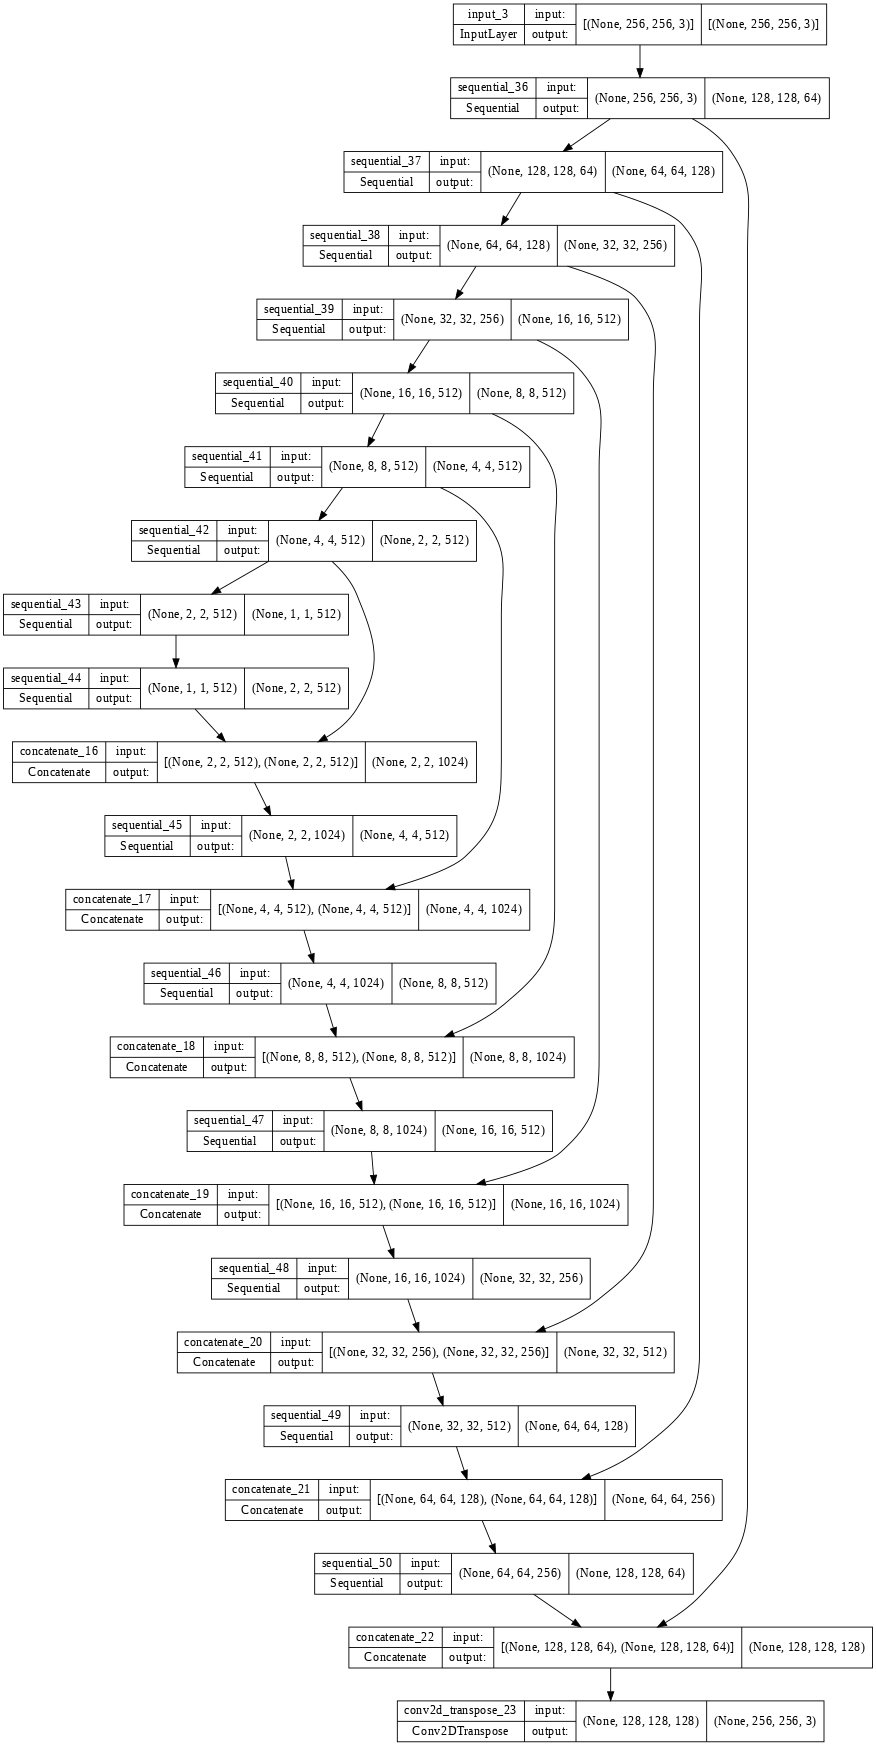

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Test the generator:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


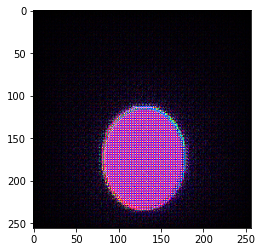

In [ ]:
gen_output = generator(tf.expand_dims(train_masks[0],0), training=False)
plt.imshow(gen_output[0, ...])

### Define the generator loss

cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image.

- The generator loss uses sigmoid cross-entropy loss of the generated images and an array of ones.
- L1 loss, which is a MAE (mean absolute error), is also used between the generated image and the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the original pix2pix paper.

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  target = tf.cast(target, tf.float32)
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  
  return total_gen_loss, gan_loss, l1_loss

The training procedure for the generator is as follows:

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


# Discriminator

The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier. This means the model tries to classify whether or not each image _patch_ is real or not.

- Each block in the discriminator is: convolution -> batch normalization -> leaky ReLU.
- The shape of the output after the last layer is `(batch_size, 30, 30, 1)`.
- Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image.
- The discriminator receives 2 inputs: 
    - The input image and the target image, which it should classify as real.
    - The input image and the generated image (the output of the generator), which it should classify as fake.

Let's define the discriminator:

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualize the discriminator model architecture:

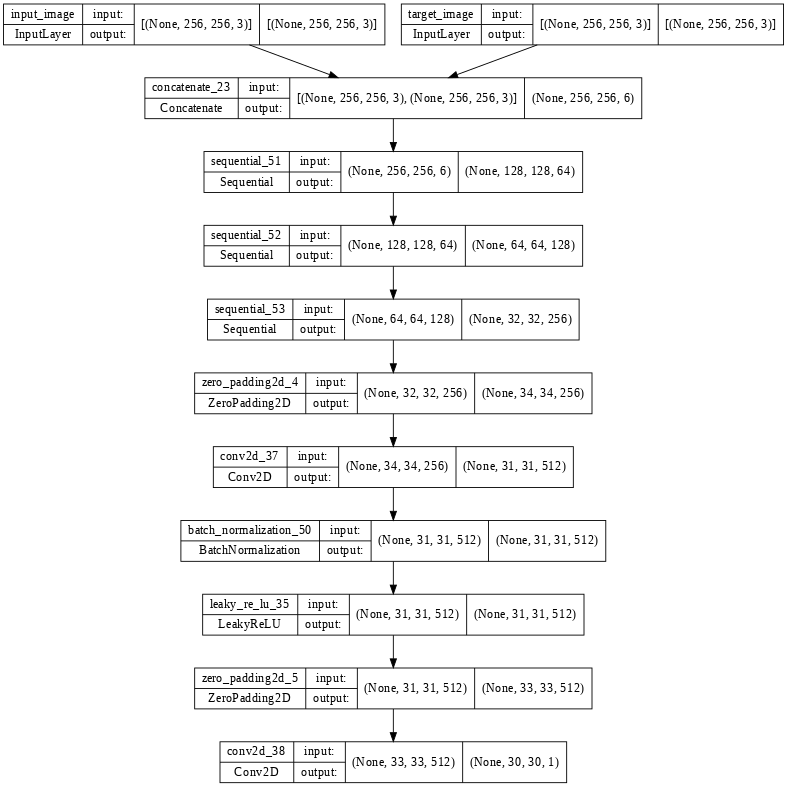

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Test the discriminator:

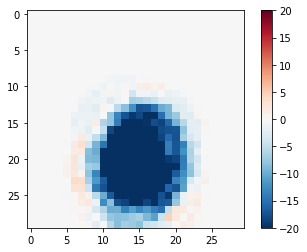

In [ ]:
disc_out = discriminator([train_masks[0][tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### Define the discriminator loss

- The discriminator_loss function takes 2 inputs: **real images** and **generated images**.
- `real_loss` is a sigmoid cross-entropy loss of the **real images** and an **array of ones(since these are the real images)**.
- `generated_loss` is a sigmoid cross-entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**.
- The `total_loss` is the sum of `real_loss` and `generated_loss`.

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  #print('--- Discriminator loss data ---')
  #print(type(disc_real_output), type(disc_generated_output))
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss
  print(type(total_disc_loss))
  print('Discriminator Loss:', total_disc_loss)
  return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer to the [pix2pix paper](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


# Optimizer and training prep

## Define the optimizers and a checkpoint-saver


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.

`training=True` is intentional here because
we need the batch statistics while the model is running on test data. If instead `training=False` is used, you only get the accumulated statistics learned from the training dataset, which is irrelavent to us

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

Test the function:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


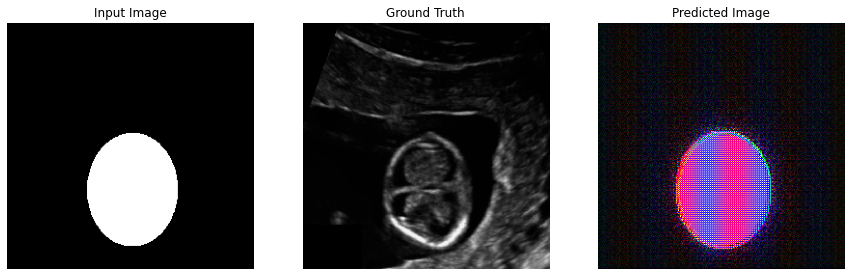

In [ ]:
mask = train_masks[0][np.newaxis, :,:,:]
image = train_images[0][np.newaxis, :,:,:]

generate_images(generator, mask, image)

## Training

- The discriminator receives the `input_image` and the `generated image` as the first input. The second input is the `input_image` and the `target_image`.
- The generator and the discriminator losses are calculated.
- The gradients of loss with respect to both the generator and the discriminator variables(inputs) are calculated and applied to the optimizer.

In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, step):
  #print('TS 1')
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    #print('TS 2')
    gen_output = generator(input_image, training=True)
    #print('TS 3')
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)
    #print('TS 4')
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    #print('TS 5')
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    print(tf.get_static_value(disc_loss))
    #print('TS 6')
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

The actual training loop. 

- Iterates over the number of steps.
- Every 10 steps print a dot (`.`).
- Every 1k steps: clear the display and run `generate_images` to show the progress.

In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = train_ds[0], test_ds[0]
  start = time.time()

  for step in range(steps):
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")
    
    
    input_image = train_ds[step]
    target = test_ds[step]
    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [ ]:
### Adding the batch axis to the data shape then add to dataset list used in fit() below
mask_dataset = []
image_dataset = []

for i in range(len(train_masks)):
  mask_copy = train_masks[i][np.newaxis,:,:,:]
  mask_dataset.append(mask_copy)

  image_copy = train_images[i][np.newaxis,:,:,:]
  image_dataset.append(image_copy)
  
print(mask_dataset[0].shape)

(1, 256, 256, 3)


Finally, run the training loop:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


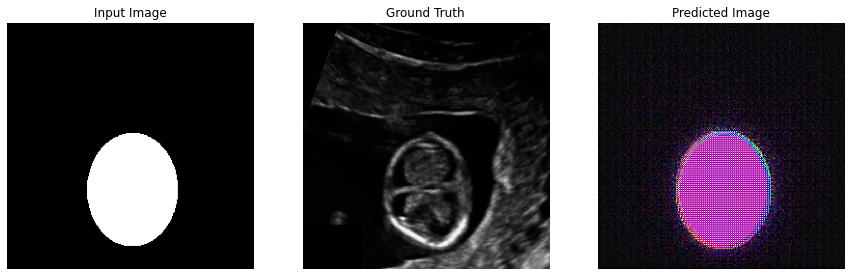

Step: 0k
<class 'tensorflow.python.framework.ops.Tensor'>
Discriminator Loss: Tensor("add_1:0", shape=(), dtype=float32)
None
<class 'tensorflow.python.framework.ops.Tensor'>
Discriminator Loss: Tensor("add_1:0", shape=(), dtype=float32)
None
<class 'tensorflow.python.framework.ops.Tensor'>
Discriminator Loss: Tensor("add_1:0", shape=(), dtype=float32)
None


KeyboardInterrupt: ignored

In [ ]:
fit(mask_dataset, image_dataset, steps=500)

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test the network

In [ ]:
!ls {checkpoint_dir}

In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))